In [24]:
# Course : CS 513 - Knowledge Discovery and Data Mining
# Group Members: Branden Bulatao, Joseph Faustino, Natalie Fortes, Isabel Sutedjo
# Id : 20005971
# Purpose : Music Happiness Predictor - Predicts the happiness of music tracks based on various features.

# Main Author: Branden Bulatao

In [25]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [26]:
# Clips outliers Q1–1.5×IQR and Q3+1.5×IQR
def clip_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Clip the values
    df[feature] = df[feature].clip(lower=lower_bound, upper=upper_bound)

    # sns.boxplot(x=f"{feature}", data=df)
    # plt.title(f"{feature} by Valence Group")
    # plt.show()
    return df

def clip_outliers_strict(df, feature):
    lower = df[feature].quantile(0.005)
    upper = df[feature].quantile(0.995)
    df[feature] = df[feature].clip(lower=lower, upper=upper)

    return df

# Check Outlier percentages of each feature
def calculate_outlier_percentage(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    outlier_percentage = len(outliers) / len(df) * 100
    return outlier_percentage

In [ ]:
# Import dataset
df = pd.read_csv("./dataset.csv")

df.drop(
    df.columns[df.columns.str.contains("unnamed", case=False)], axis=1, inplace=True
)  # drop unnamed column

df.dropna(inplace=True)  # drop rows with null values

df["valence"] = df["valence"].astype("category")
df["valence"] = df["valence"].map(
    lambda x: 0 if x < 0.5 else 1
)  # sets valence to 0 if sad, 1 if happy

# Convert 'explicit' boolean to integer (0/1)
df["explicit"] = df["explicit"].astype(int)

# One-hot encode categorical features
df = pd.get_dummies(
    df, columns=["key", "time_signature", "track_genre"], drop_first=True
)

# X = df.drop(['track_id', 'artists', 'album_name', 'track_name', 'valence'], axis=1)
X = df.drop(
    ["track_id", "artists", "album_name", "track_name", "valence", "duration_ms"],
    axis=1,
)
y = df["valence"]

# Identify numeric features to scale
numeric_features = [
    # "duration_ms",
    # "popularity",
    # "tempo",
    # "loudness",
    "danceability",
    "energy",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
]

numeric_high_value_features = [
    "popularity",
    "tempo",
    "loudness",
]

# All other features (binary or one-hot) are left as-is
non_scaled_features = [
    col
    for col in X.columns
    if col not in (numeric_features + numeric_high_value_features)
]
# non_scaled_features = [col for col in X.columns if col not in numeric_high_value_features]

# Clip extreme outliers >5%
# threshold = 5
# for col in numeric_features + numeric_high_value_features:
#     percent = calculate_outlier_percentage(X, col)
#     if percent > threshold:
#         X = clip_outliers_strict(X, col)
#         print(f"Clipped {col} (outliers were {percent:.2f}%)")


# ColumnTransformer for selective scaling
preprocessor = ColumnTransformer(
    transformers=[
        # ("num", StandardScaler(), numeric_features),
        ("num", "passthrough", numeric_features),
        ("num2", MinMaxScaler(), numeric_high_value_features),
        ("pass", "passthrough", non_scaled_features),
    ]
)

# Fit and transform the data
X_processed = preprocessor.fit_transform(X)

# Reconstruct a DataFrame (optional, for inspection/debugging)
final_features = numeric_features + numeric_high_value_features + non_scaled_features
X_processed = pd.DataFrame(X_processed, columns=final_features)
# X_processed = X_processed.apply(pd.to_numeric)  # <-- this line fixes your problem

# Train the code
attr_train, attr_test, target_train, target_test = train_test_split(
    X_processed, y, test_size=0.3, random_state=42
)

Clipped speechiness (outliers were 11.59%)
Clipped instrumentalness (outliers were 22.15%)
Clipped liveness (outliers were 7.58%)
Clipped loudness (outliers were 5.41%)


In [28]:
# Train Naive Bayes model
model = GaussianNB()
model.fit(attr_train, target_train)

# Make Prediction
target_pred = model.predict(attr_test)

In [29]:
# Evaluate model
accuracy = accuracy_score(target_test, target_pred)
conf_matrix = confusion_matrix(target_test, target_pred)
class_report = classification_report(target_test, target_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Accuracy: 0.6907

Confusion Matrix:
 [[11987  6584]
 [ 3993 11636]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.65      0.69     18571
           1       0.64      0.74      0.69     15629

    accuracy                           0.69     34200
   macro avg       0.69      0.69      0.69     34200
weighted avg       0.70      0.69      0.69     34200



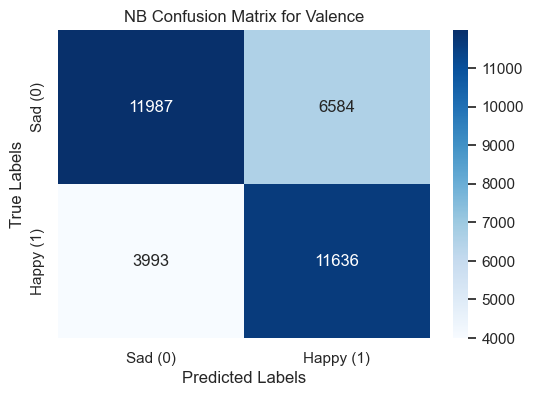

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(target_test, target_pred)

# Create the heatmap
plt.figure(figsize=(6, 4))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", ax=ax)

# Labels, title, and ticks
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("NB Confusion Matrix for Valence")
ax.xaxis.set_ticklabels(["Sad (0)", "Happy (1)"])
ax.yaxis.set_ticklabels(["Sad (0)", "Happy (1)"])

plt.show()

In [31]:
test_actual = attr_test  # Copy attr_test
test_actual["target_pred"] = target_pred  # Create new column for prediction values
test_actual["test_actual"] = target_test  # Create new column for actual values
# test_actual.head()  # Show table

false_positives = test_actual[
    (test_actual["target_pred"] == 1) & (test_actual["test_actual"] == 0)
]

false_negatives = test_actual[
    (test_actual["target_pred"] == 0) & (test_actual["test_actual"] == 1)
]

true_positives = test_actual[
    (test_actual["target_pred"] == 1) & (test_actual["test_actual"] == 1)
]

true_negatives = test_actual[
    (test_actual["target_pred"] == 0) & (test_actual["test_actual"] == 0)
]

print(false_positives)
print(false_negatives)
# false_positives.describe()

       danceability energy speechiness acousticness instrumentalness liveness  \
19261         0.469  0.183      0.0407        0.829              0.0     0.71   
115           0.633  0.299      0.0353        0.833              0.0    0.109   
88580         0.786  0.696       0.352        0.183              0.0    0.123   
60735         0.911  0.616       0.272        0.569          0.00795    0.154   
3241          0.416  0.964       0.112     0.000023         0.000875    0.473   
...             ...    ...         ...          ...              ...      ...   
84333         0.653  0.472      0.0353       0.0554         0.000077    0.397   
52481         0.472  0.181       0.034        0.869              0.0    0.142   
103113        0.637  0.745      0.0748       0.0173         0.000554   0.0372   
112151        0.748  0.646      0.0652       0.0419            0.438     0.18   
53782         0.687  0.915      0.0411        0.021         0.000006    0.151   

       popularity     tempo

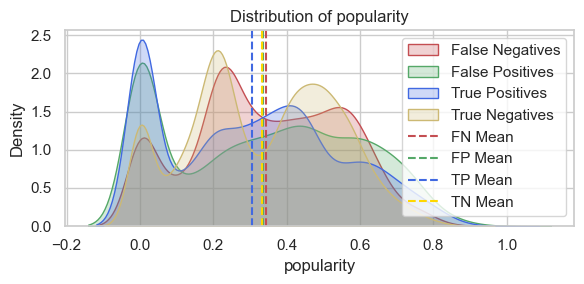

Stats for 'popularity':
  False Negatives - mean: 0.3438, std: 0.2031
  False Positives - mean: 0.3347, std: 0.2536
  True Positives  - mean: 0.3060, std: 0.2360
  True Negatives  - mean: 0.3325, std: 0.1991
------------------------------------------------------------


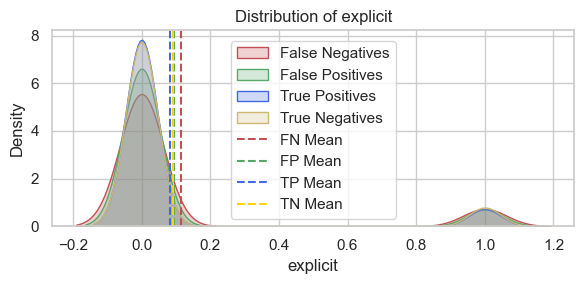

Stats for 'explicit':
  False Negatives - mean: 0.1153, std: 0.3195
  False Positives - mean: 0.0956, std: 0.2941
  True Positives  - mean: 0.0841, std: 0.2775
  True Negatives  - mean: 0.0918, std: 0.2887
------------------------------------------------------------


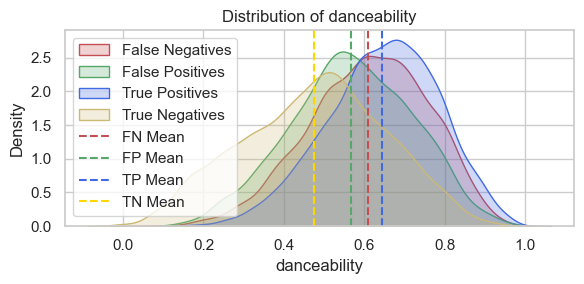

Stats for 'danceability':
  False Negatives - mean: 0.6098, std: 0.1471
  False Positives - mean: 0.5666, std: 0.1518
  True Positives  - mean: 0.6447, std: 0.1396
  True Negatives  - mean: 0.4754, std: 0.1786
------------------------------------------------------------


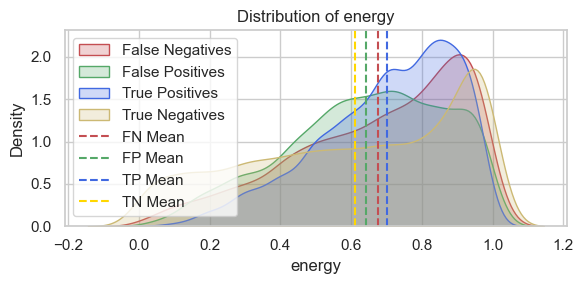

Stats for 'energy':
  False Negatives - mean: 0.6762, std: 0.2387
  False Positives - mean: 0.6410, std: 0.2243
  True Positives  - mean: 0.7007, std: 0.1933
  True Negatives  - mean: 0.6097, std: 0.2983
------------------------------------------------------------


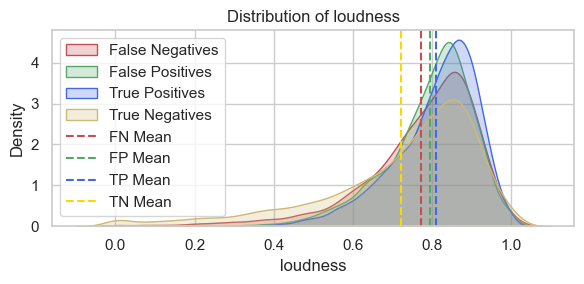

Stats for 'loudness':
  False Negatives - mean: 0.7720, std: 0.1484
  False Positives - mean: 0.7945, std: 0.1116
  True Positives  - mean: 0.8094, std: 0.1086
  True Negatives  - mean: 0.7217, std: 0.2049
------------------------------------------------------------


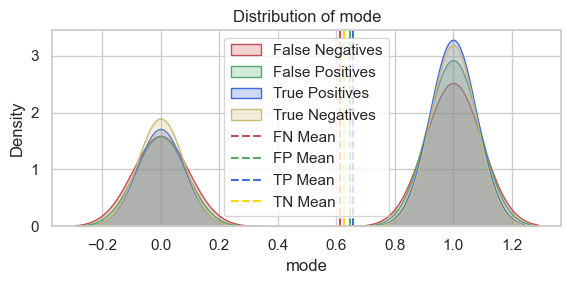

Stats for 'mode':
  False Negatives - mean: 0.6132, std: 0.4871
  False Positives - mean: 0.6489, std: 0.4774
  True Positives  - mean: 0.6571, std: 0.4747
  True Negatives  - mean: 0.6271, std: 0.4836
------------------------------------------------------------


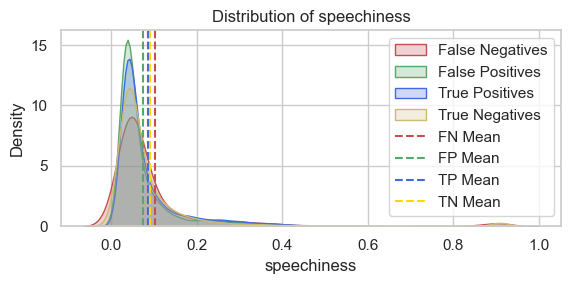

Stats for 'speechiness':
  False Negatives - mean: 0.1033, std: 0.1485
  False Positives - mean: 0.0754, std: 0.0800
  True Positives  - mean: 0.0859, std: 0.0895
  True Negatives  - mean: 0.0921, std: 0.1327
------------------------------------------------------------


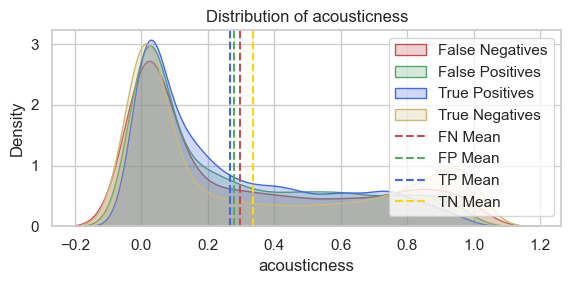

Stats for 'acousticness':
  False Negatives - mean: 0.2971, std: 0.3324
  False Positives - mean: 0.2785, std: 0.3012
  True Positives  - mean: 0.2672, std: 0.2767
  True Negatives  - mean: 0.3354, std: 0.3757
------------------------------------------------------------


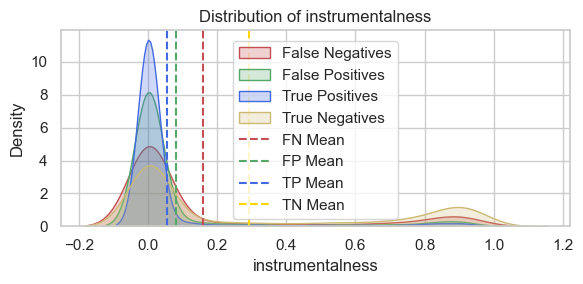

Stats for 'instrumentalness':
  False Negatives - mean: 0.1583, std: 0.3066
  False Positives - mean: 0.0800, std: 0.2208
  True Positives  - mean: 0.0549, std: 0.1829
  True Negatives  - mean: 0.2925, std: 0.3816
------------------------------------------------------------


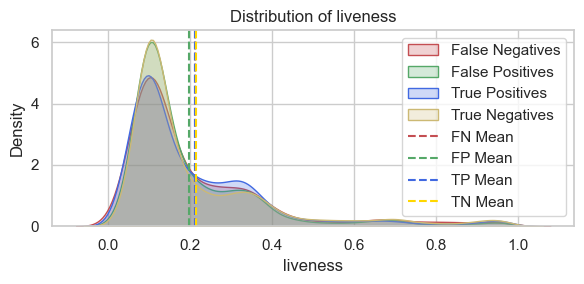

Stats for 'liveness':
  False Negatives - mean: 0.2123, std: 0.1860
  False Positives - mean: 0.1981, std: 0.1681
  True Positives  - mean: 0.2121, std: 0.1825
  True Negatives  - mean: 0.2152, std: 0.1907
------------------------------------------------------------


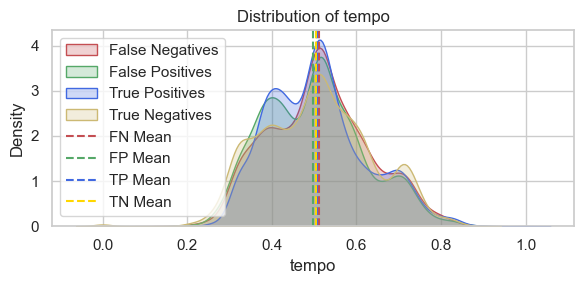

Stats for 'tempo':
  False Negatives - mean: 0.5118, std: 0.1191
  False Positives - mean: 0.4984, std: 0.1187
  True Positives  - mean: 0.5071, std: 0.1159
  True Negatives  - mean: 0.5048, std: 0.1295
------------------------------------------------------------


In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

df_no_genres = df.loc[:, ~df.columns.str.contains("track_genre")]

feature_cols = [
    col
    for col in df_no_genres.columns
    if col
    not in [
        "target_actual",
        "target_pred",
        "track_id",
        "artists",
        "album_name",
        "track_name",
        "valence",
    ]
]

KF_df = df.drop(columns="valence")
for col in df_no_genres.select_dtypes(include=["float", "int"]).columns:
    if col == "valence" or col == "duration_ms": continue
   
    plt.figure(figsize=(6, 3))

    # KDE plots
    sns.kdeplot(false_negatives[col], label="False Negatives", fill=True, color="r")
    sns.kdeplot(false_positives[col], label="False Positives", fill=True, color="g")
    sns.kdeplot(
        true_positives[col], label="True Positives", fill=True, color="royalblue"
    )
    sns.kdeplot(true_negatives[col], label="True Negatives", fill=True, color="y")

    # Vertical lines for means
    plt.axvline(false_negatives[col].mean(), color="r", linestyle="--", label="FN Mean")
    plt.axvline(false_positives[col].mean(), color="g", linestyle="--", label="FP Mean")
    plt.axvline(
        true_positives[col].mean(), color="royalblue", linestyle="--", label="TP Mean"
    )
    plt.axvline(
        true_negatives[col].mean(), color="gold", linestyle="--", label="TN Mean"
    )

    plt.title(f"Distribution of {col}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Stats for '{col}':")
    print(
        f"  False Negatives - mean: {false_negatives[col].mean():.4f}, std: {false_negatives[col].std():.4f}"
    )
    print(
        f"  False Positives - mean: {false_positives[col].mean():.4f}, std: {false_positives[col].std():.4f}"
    )
    print(
        f"  True Positives  - mean: {true_positives[col].mean():.4f}, std: {true_positives[col].std():.4f}"
    )
    print(
        f"  True Negatives  - mean: {true_negatives[col].mean():.4f}, std: {true_negatives[col].std():.4f}"
    )
    print("-" * 60)

['popularity', 'explicit', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'time_signature_1', 'time_signature_3', 'time_signature_4', 'time_signature_5']
------------------------------------------------------------
1) Heatmap of feature means per outcome
------------------------------------------------------------


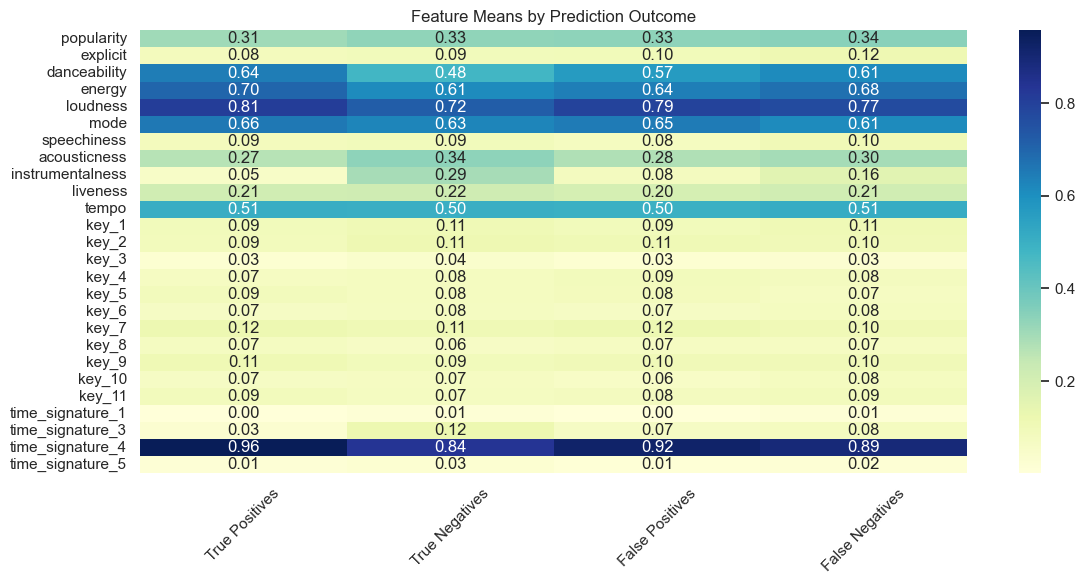

------------------------------------------------------------
2) Bar Plots of each feature
------------------------------------------------------------
instrumentalness std deviation:  0.10688898629369652


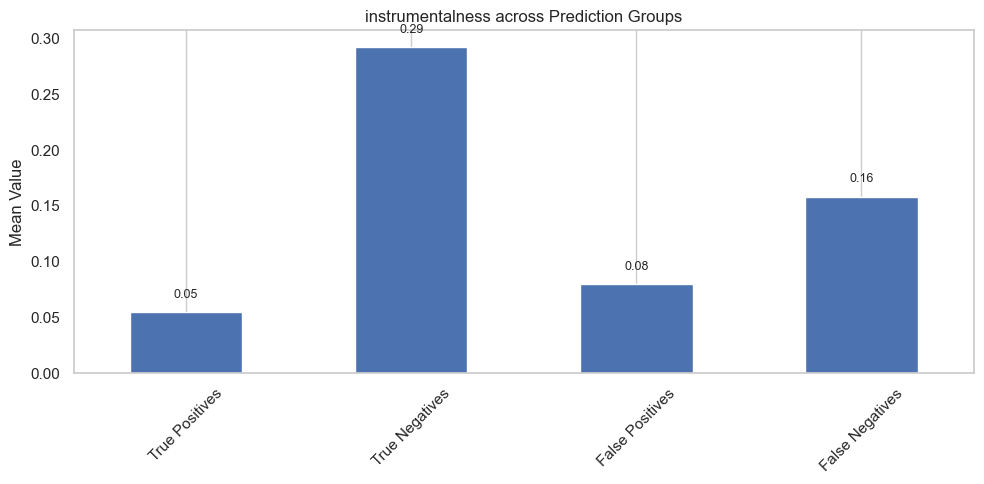

danceability std deviation:  0.07315053822030257


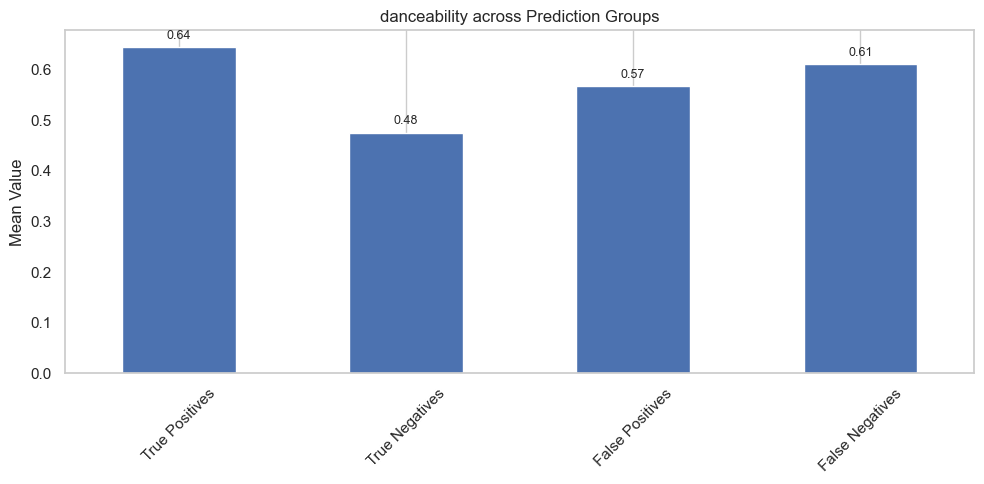

time_signature_4 std deviation:  0.05158816288533531


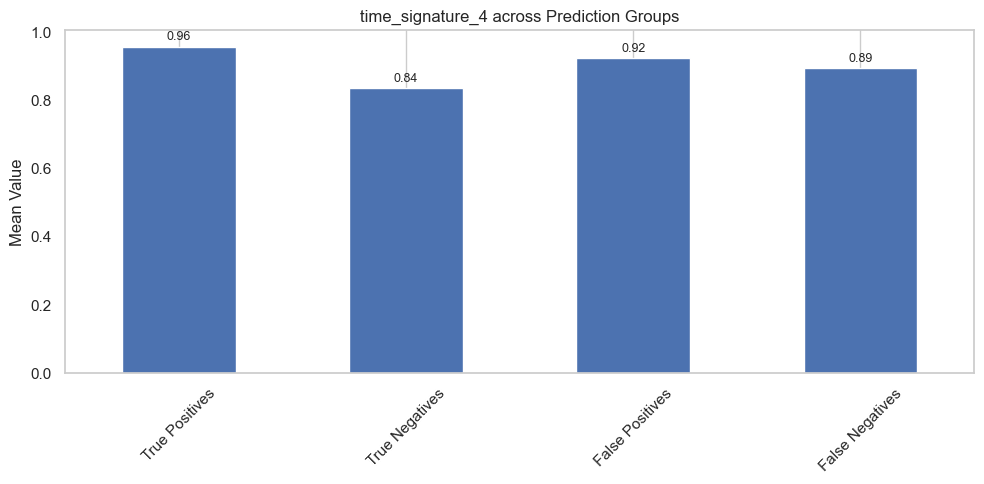

energy std deviation:  0.039877932110559566


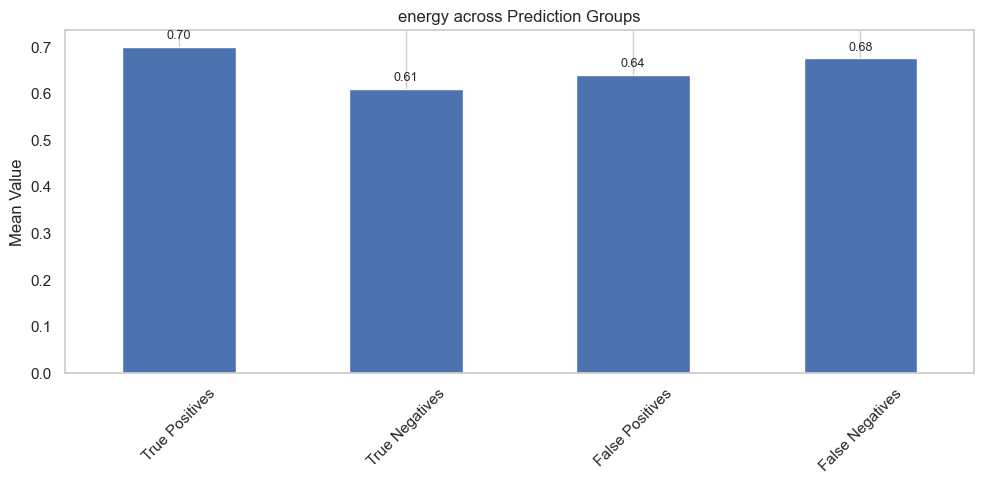

loudness std deviation:  0.038348299070995025


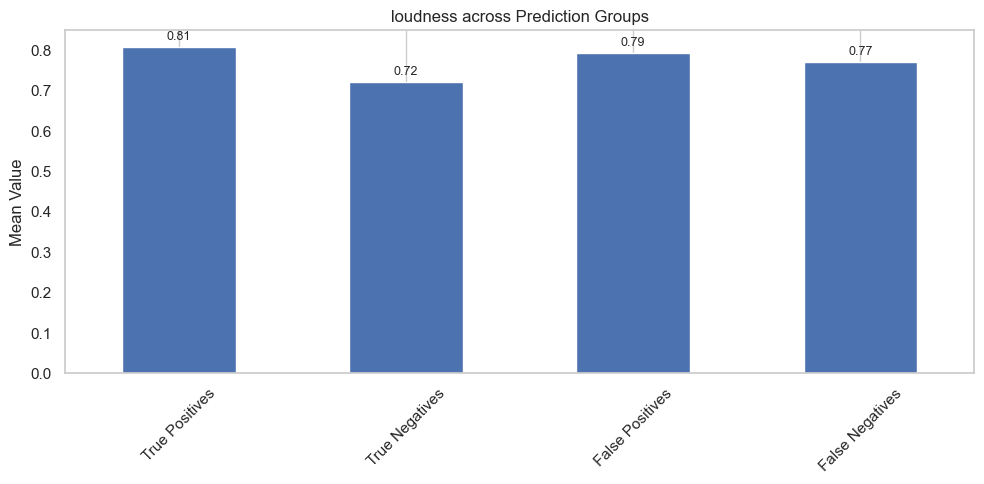

time_signature_3 std deviation:  0.03780372786078061


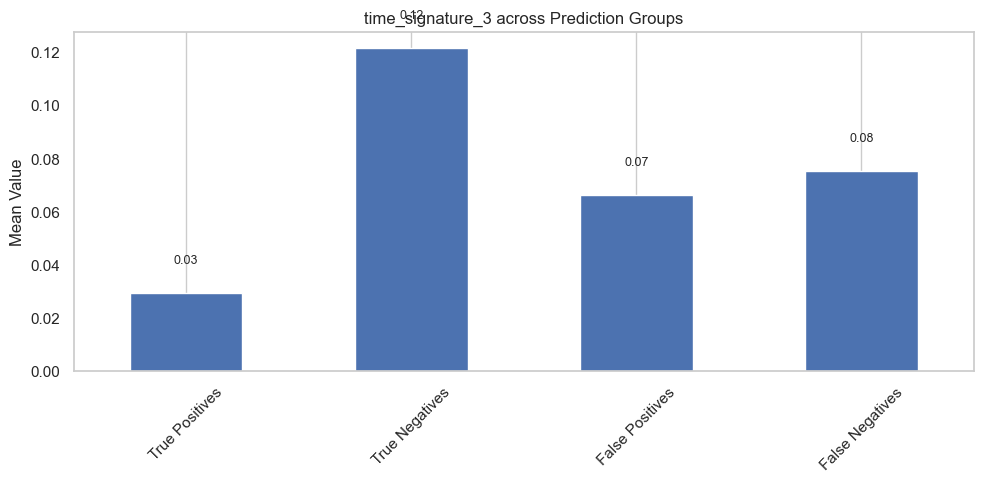

acousticness std deviation:  0.02992106184997779


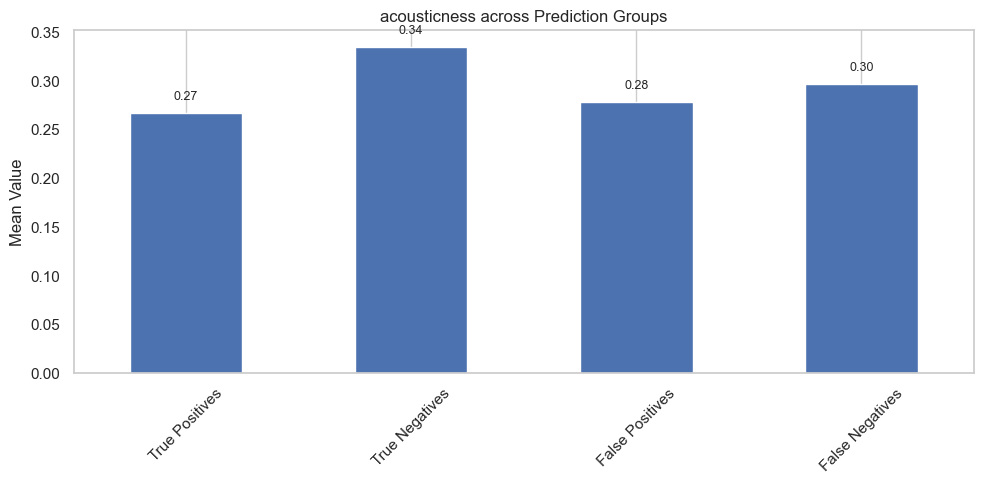

mode std deviation:  0.02009323268074094


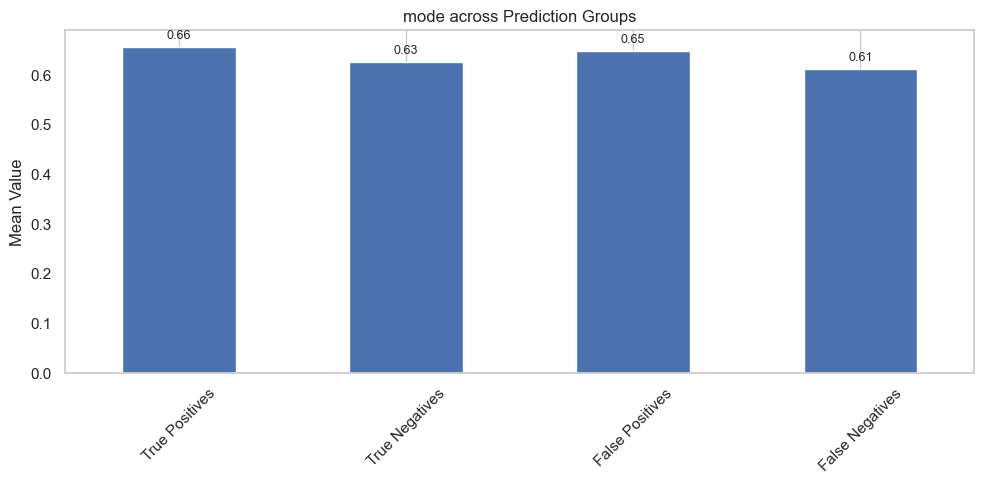

popularity std deviation:  0.016247680244636846


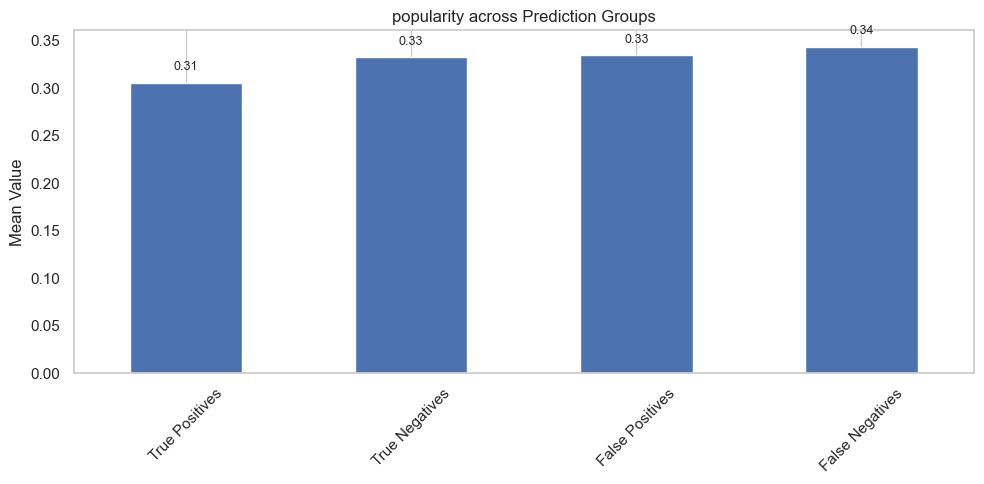

explicit std deviation:  0.013317808168232295


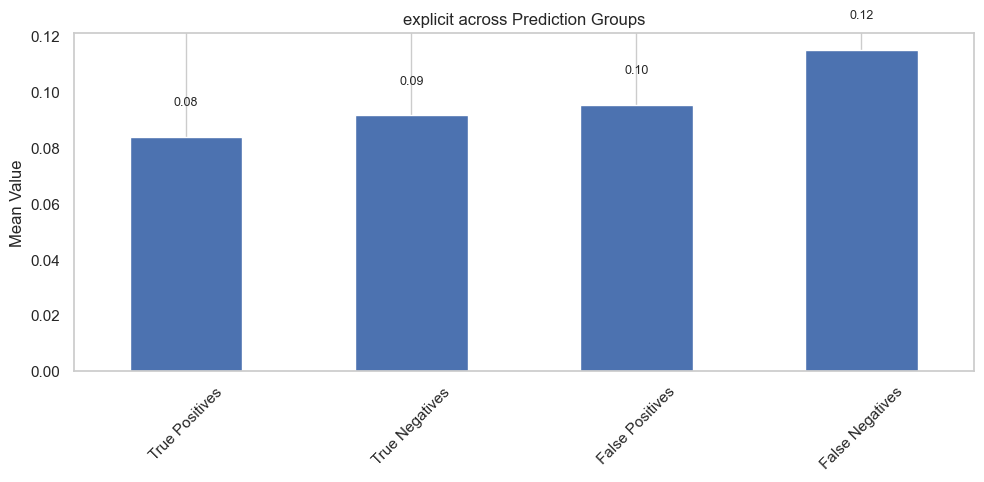

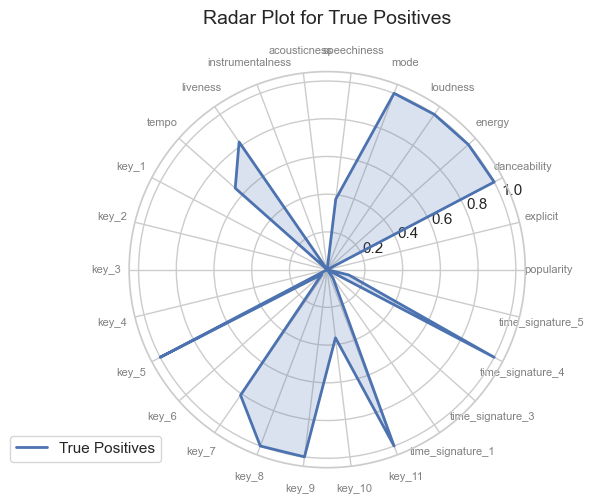

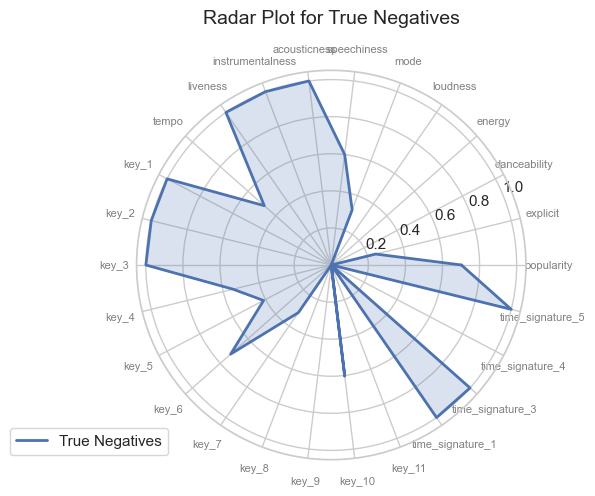

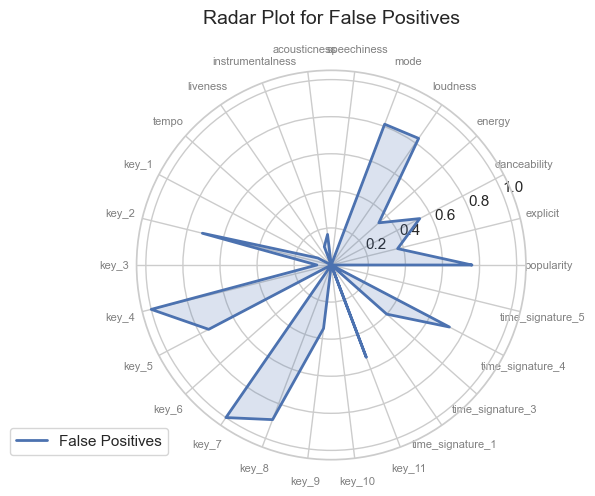

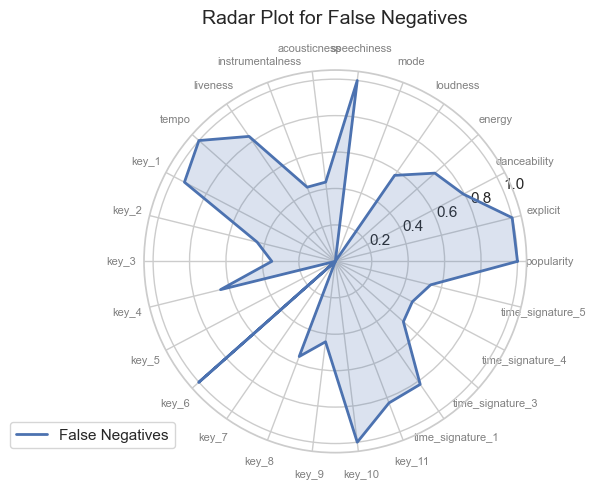

In [33]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

df_no_genres = df.loc[:, ~df.columns.str.contains("track_genre")]

# Features only (adjust as needed)
feature_cols = [
    col
    for col in df_no_genres.columns
    if col
    not in [
        "target_actual",
        "target_pred",
        "track_id",
        "artists",
        "album_name",
        "track_name",
        "valence",
        "duration_ms",
    ]
]

print(feature_cols)

# Mean summary per category
summary_df = pd.DataFrame(
    {
        "True Positives": true_positives[feature_cols].mean(),
        "True Negatives": true_negatives[feature_cols].mean(),
        "False Positives": false_positives[feature_cols].mean(),
        "False Negatives": false_negatives[feature_cols].mean(),
        # "All Data": df[feature_cols].mean(),
    }
)

# Transpose for easier plotting
summary_df = summary_df.astype(float)
summary_df = summary_df.T

# Optional: Normalize columns for radar/spider-style plots
summary_norm = (summary_df - summary_df.min()) / (summary_df.max() - summary_df.min())

# --- Plot 1: Heatmap of Means per Outcome Type ---
print("-" * 60)
print("1) Heatmap of feature means per outcome")
print("-" * 60)

plt.figure(figsize=(12, 6))
sns.heatmap(summary_df.T, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Feature Means by Prediction Outcome")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Plot 2: Comparison Bar Plot for One Feature at a Time ---
# Choose top 5 most differing features (by std deviation across groups)
print("-" * 60)
print("2) Bar Plots of each feature")
print("-" * 60)

top_diff_features = summary_df.std().sort_values(ascending=False).head(10).index

for feature in top_diff_features:
    print(feature + " std deviation: ", summary_df[feature].std())

    ax = summary_df[feature].plot(
        kind="bar", title=f"{feature} across Prediction Groups", ylabel="Mean Value"
    )

    # Add value labels above each bar
    for i, value in enumerate(summary_df[feature]):
        ax.text(i, value + 0.01, f"{value:.2f}", ha="center", va="bottom", fontsize=9)

    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

# --- Plot 3: Radar Plot  ---
try:
    from math import pi

    categories = list(summary_norm.columns)
    groups = summary_norm.index

    for group in groups:
        values = summary_norm.loc[group].tolist()
        values += values[:1]  # repeat the first value to close the circle

        angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
        angles += angles[:1]

        plt.figure(figsize=(6, 6))
        ax = plt.subplot(111, polar=True)
        plt.xticks(angles[:-1], categories, color="grey", size=8)

        ax.plot(angles, values, linewidth=2, linestyle="solid", label=group)
        ax.fill(angles, values, alpha=0.2)

        plt.title(f"Radar Plot for {group}", size=14, y=1.1)
        plt.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1))
        plt.tight_layout()
        plt.show()
except ImportError:
    print("Radar plot skipped (requires polar plotting support).")

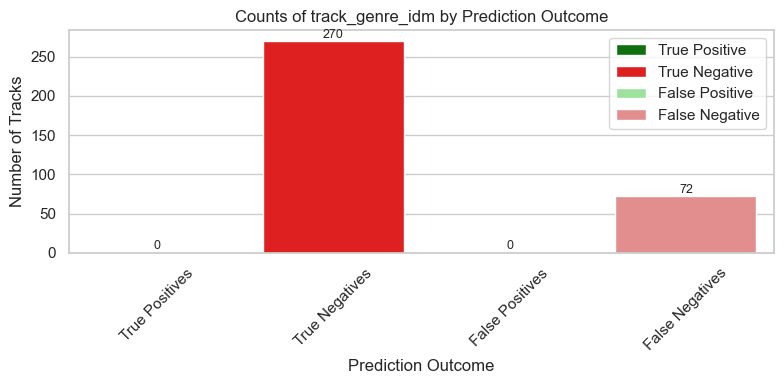

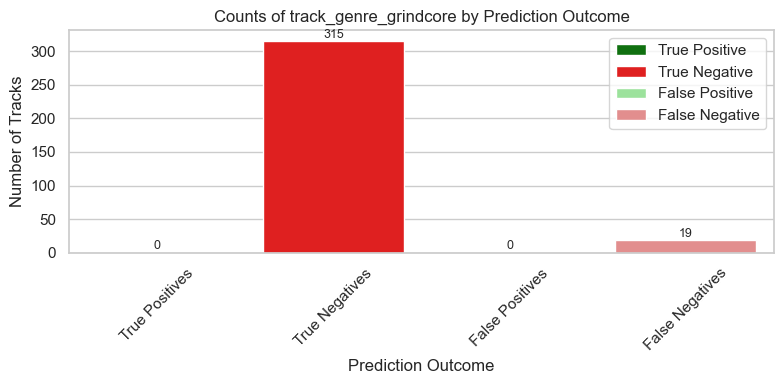

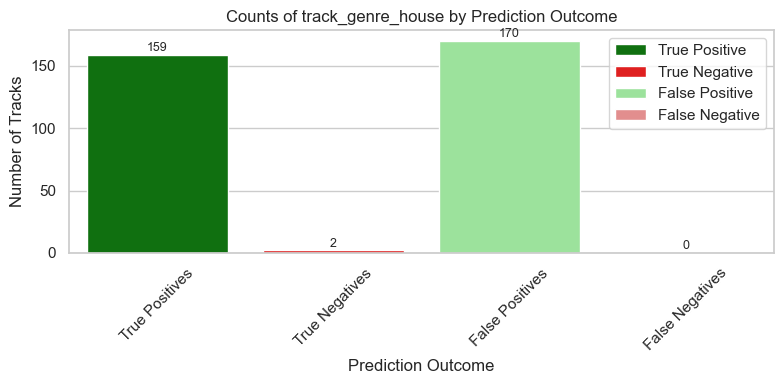

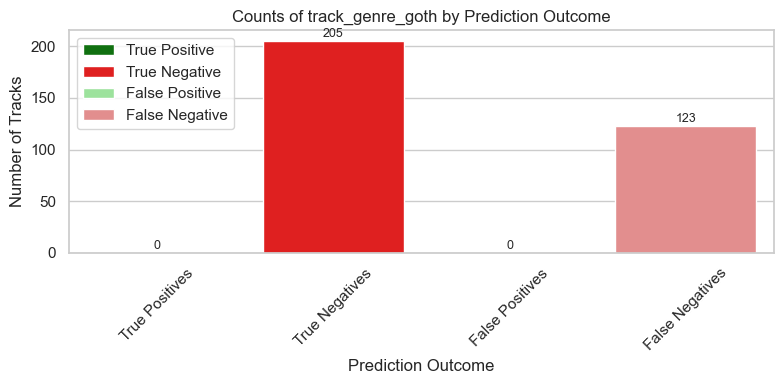

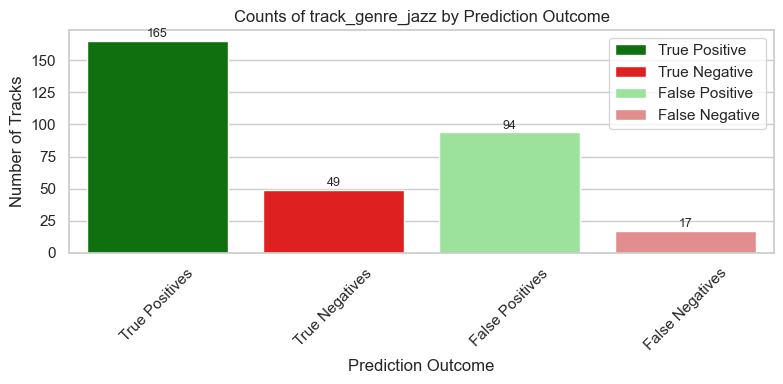

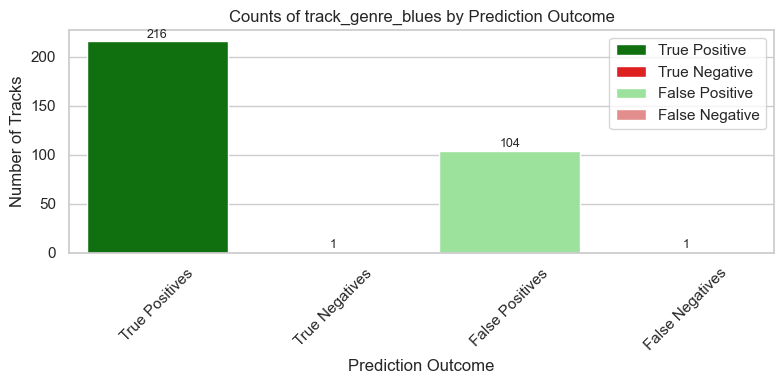

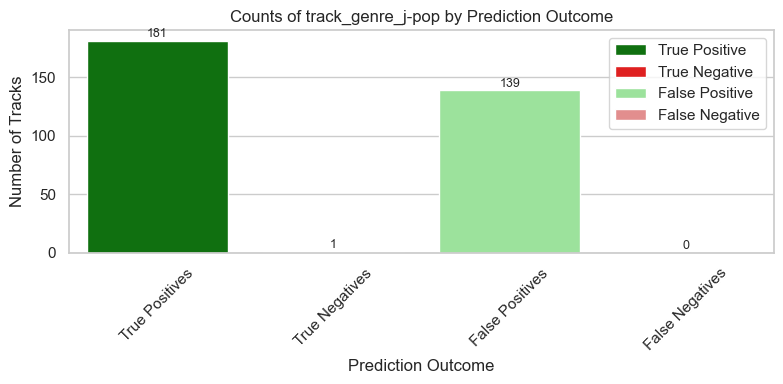

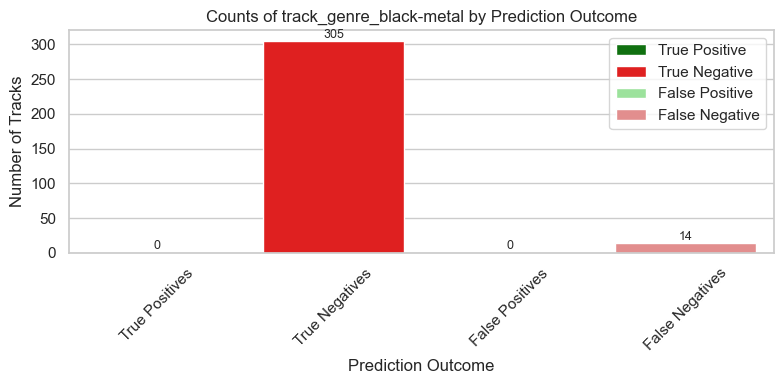

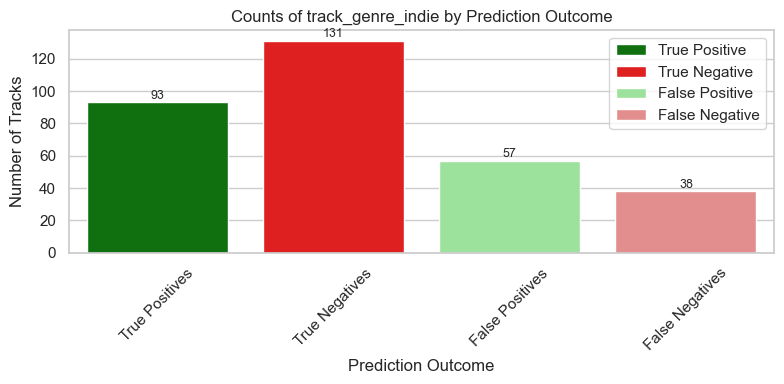

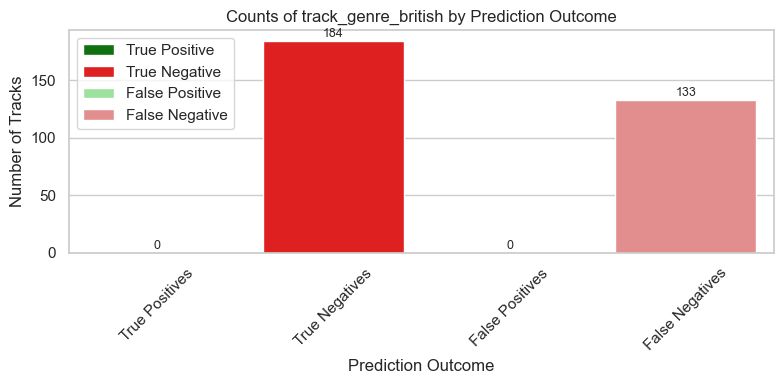

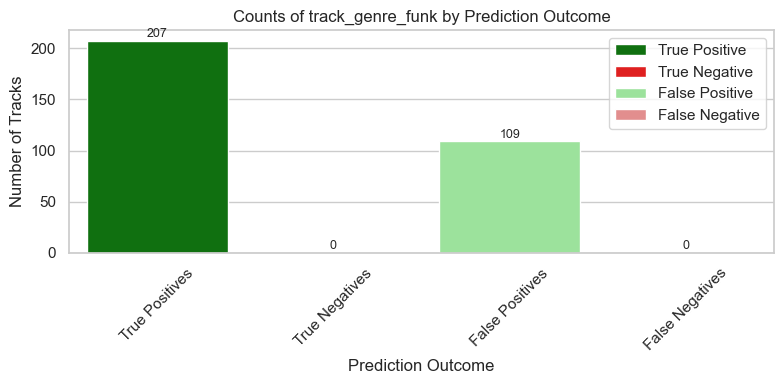

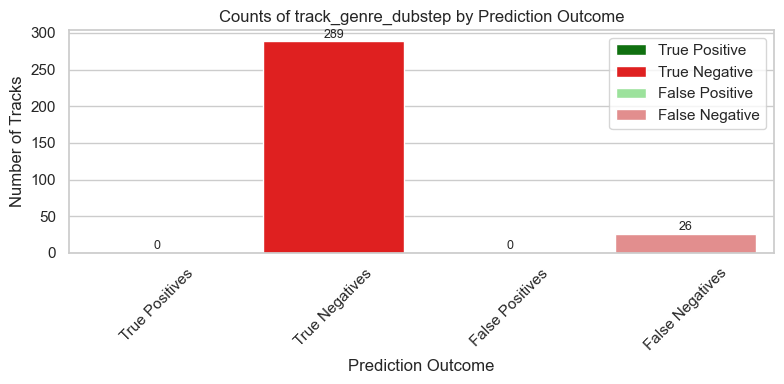

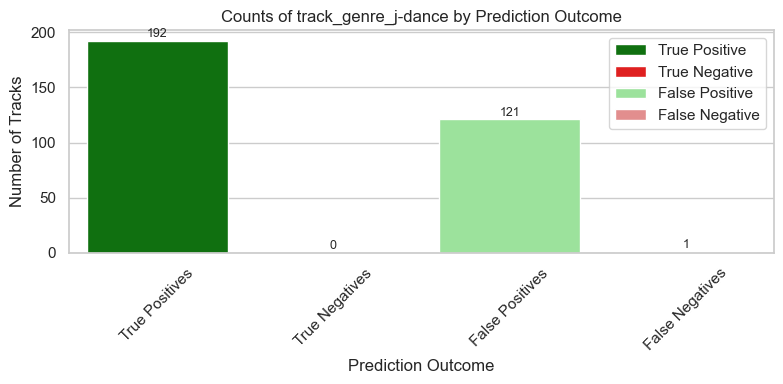

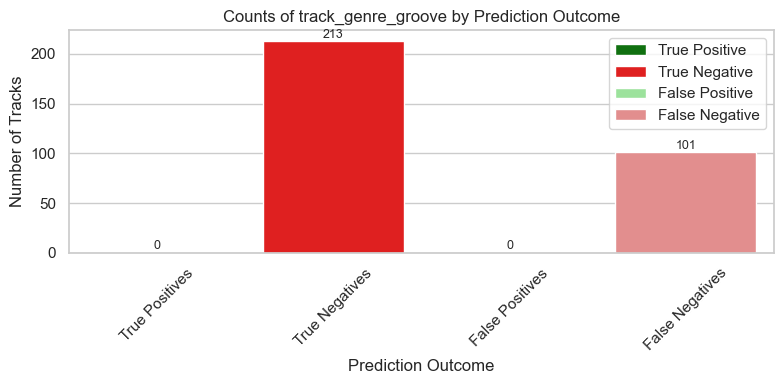

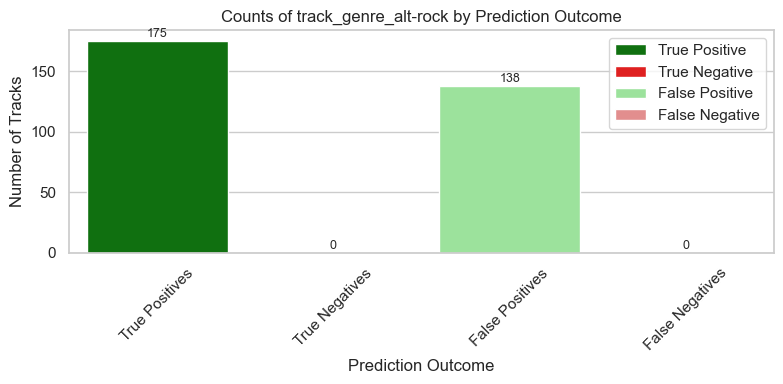

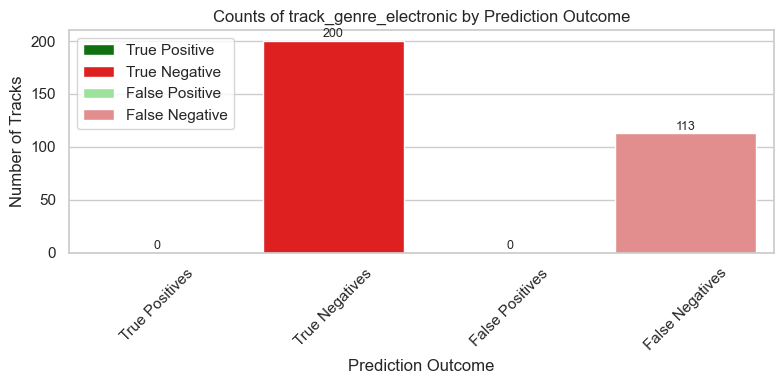

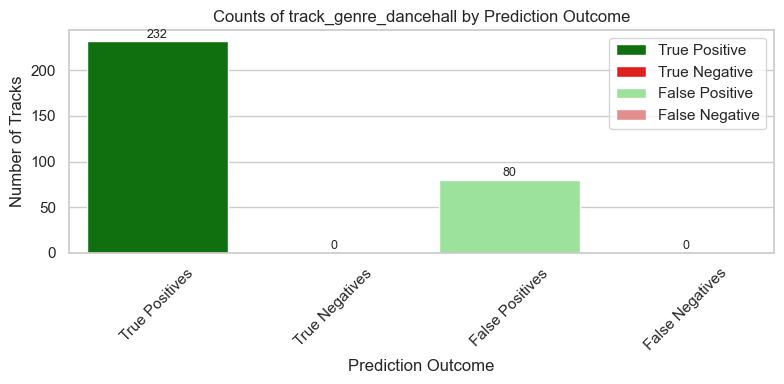

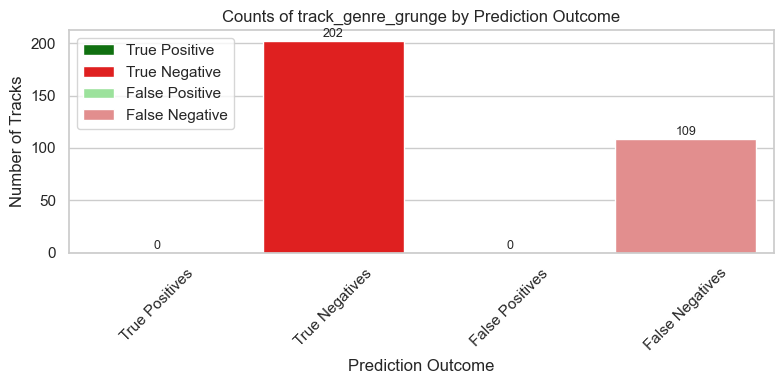

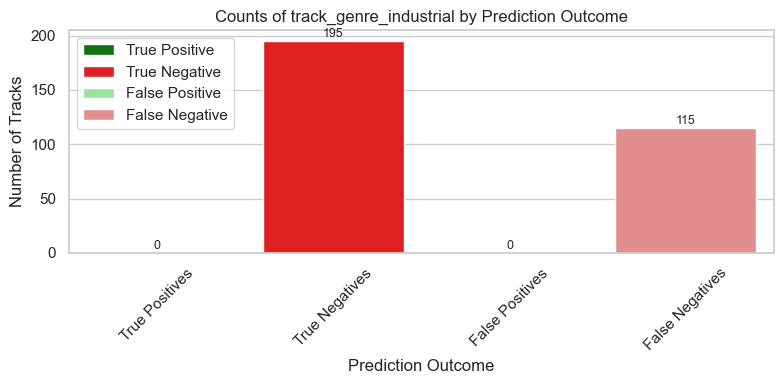

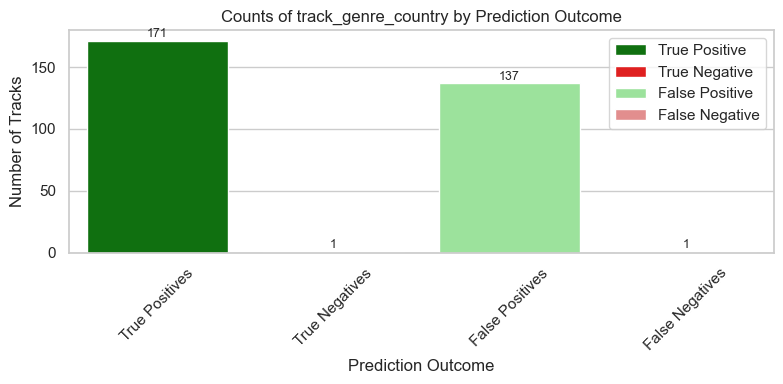

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: prettier style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# --- Genre Counts per Prediction Outcome ---

# Ensure genre columns are all 0 or 1
genre_cols = [col for col in df.columns if col.startswith("track_genre")]

# If genre values are probabilities or standardized, convert to binary
for col in genre_cols:
    df[col] = (df[col] > 0.5).astype(int)  # Adjust threshold if needed
    # df[col].apply(pd.Series.unique)

# Define the prediction outcome groups
groups = {
    "True Positives": true_positives,
    "True Negatives": true_negatives,
    "False Positives": false_positives,
    "False Negatives": false_negatives,
}

# Count genres per group
genre_counts = {
    # group_name: group_df[genre_cols].clip(lower=0).sum() for group_name, group_df in groups.items()
    group_name: (group_df[genre_cols] > 0).astype(int).sum()
    for group_name, group_df in groups.items()
}

# genre_matrix = (df[genre_cols] != -0.09407250308929431).astype(int)
# print(genre_matrix)

# Create a DataFrame
genre_counts_df = pd.DataFrame(genre_counts).T  # Outcomes as rows
# genre_counts_df.to_csv('output.csv', index=False)

top_10_popular_genres = [
    "track_genre_pop-film", 
    "track_genre_k-pop", 
    "track_genre_chill", 
    "track_genre_sad", 
    "track_genre_grunge", 
    "track_genre_indian", 
    "track_genre_anime", 
    "track_genre_emo", 
    "track_genre_sertanejo", 
    "track_genre_pop",
    "track_genre_indie"
]
# top_genres = genre_counts_df.sum(axis=0).sort_values(ascending=False).index
top_genres = genre_counts_df.sum(axis=0).sort_values(ascending=False).head(20).index

def get_top_10_popular(genre):
    if genre not in top_10_popular_genres: 
        return True
    else:
        return False

# Plot barplot for each genre
for genre in top_genres:
    # if get_top_10_popular(genre): 
    #     continue
    
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(
        x=genre_counts_df.index,
        y=genre_counts_df[genre].values,
        hue=["True Positive", "True Negative", "False Positive", "False Negative"],
        palette=["green", "red", "lightgreen", "lightcoral"],
    )

    # Add value labels above bars
    for i, value in enumerate(genre_counts_df[genre].values):
        ax.text(i, value + 0.5, str(int(value)), ha="center", va="bottom", fontsize=9)

    plt.title(f"Counts of {genre} by Prediction Outcome")
    plt.ylabel("Number of Tracks")
    plt.xlabel("Prediction Outcome")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    

In [35]:
# # Optional: for nicer plot styles
# sns.set(style="whitegrid")
# plt.rcParams["figure.figsize"] = (10, 5)

# # df_no_genres = df.loc[:, ~df.columns.str.contains("track_genre")]

# # Features only (adjust as needed)
# feature_cols = [
#     col
#     for col in df.columns
#     if col
#     not in [
#         "target_actual",
#         "target_pred",
#         "track_id",
#         "artists",
#         "album_name",
#         "track_name",
#         "valence",
#     ]
# ]

# print(feature_cols)

# # Mean summary per category
# summary_df = pd.DataFrame(
#     {
#         "False Negatives": false_negatives[feature_cols].mean(),
#         "False Positives": false_positives[feature_cols].mean(),
#         "True Positives": true_positives[feature_cols].mean(),
#         "True Negatives": true_negatives[feature_cols].mean(),
#         # "All Data": df[feature_cols].mean(),
#     }
# )

# # Transpose for easier plotting
# summary_df = summary_df.T


# # --- Comparison Bar Plot for of each genre  ---
# # Choose top 10 most differing features that are ONLY GENRES (by std deviation across groups)
# diff_features = (
#     summary_df.filter(like="track_genre")
#     .std()
#     .sort_values(ascending=False)
#     # .head(10)
#     .index
# )

# for feature in diff_features:
#     summary_df[feature].plot(
#         kind="bar", title=f"{feature} across Prediction Groups", ylabel="Mean Value"
#     )
#     plt.xticks(rotation=45)
#     plt.grid(axis="y")
#     plt.tight_layout()
#     plt.show()